In [3]:
# imports
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt

In [4]:
img_h = img_w = 28             # MNIST images are 28x28
img_size_flat = img_h * img_w  # 28x28=784, the total number of pixels
n_classes = 10                 # Number of classes, one class per digit

In [5]:
def load_data(mode='train'):
    """
    Function to (download and) load the MNIST data
    :param mode: train or test
    :return: images and the corresponding labels
    """
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    if mode == 'train':
        x_train, y_train, x_valid, y_valid = mnist.train.images, mnist.train.labels, \
                                             mnist.validation.images, mnist.validation.labels
        return x_train, y_train, x_valid, y_valid
    elif mode == 'test':
        x_test, y_test = mnist.test.images, mnist.test.labels
    return x_test, y_test


def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y


def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [8]:
# Load MNIST data
x_train, y_train, x_valid, y_valid = load_data(mode='train')
print("Size of:")
print("- Training-set:\t\t{}".format(len(y_train)))
print("- Validation-set:\t{}".format(len(y_valid)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Validation-set:	5000


In [9]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_valid:\t{}'.format(x_valid.shape))
print('y_valid:\t{}'.format(y_valid.shape))

x_train:	(55000, 784)
y_train:	(55000, 10)
x_valid:	(5000, 784)
y_valid:	(5000, 10)


In [10]:
y_valid[:5, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
# Hyper-parameters
epochs = 10             # Total number of training epochs
batch_size = 100        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.001   # The optimization initial learning rate

h1 = 200                # number of nodes in the 1st hidden layer

In [12]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

In [13]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [14]:
# Create the graph for the linear model
# Placeholders for inputs (x) and outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')

In [15]:
# Create a fully-connected layer with h1 nodes as hidden layer
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
# Create a fully-connected layer with n_classes nodes as output layer
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

In [17]:
# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

In [18]:
# Create the op for initializing all variables
init = tf.global_variables_initializer()

In [19]:
# Create an interactive session (to keep the session in the other cells)
sess = tf.InteractiveSession()
# Initialize all variables
sess.run(init)
# Number of training iterations in each epoch
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    # Randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(x_train, y_train)
    for iteration in range(num_tr_iter):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: x_valid[:1000], y: y_valid[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.28,	Training Accuracy=57.0%
iter 100:	 Loss=0.66,	Training Accuracy=83.0%
iter 200:	 Loss=0.28,	Training Accuracy=94.0%
iter 300:	 Loss=0.34,	Training Accuracy=91.0%
iter 400:	 Loss=0.22,	Training Accuracy=93.0%
iter 500:	 Loss=0.17,	Training Accuracy=94.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.23, validation accuracy: 93.5%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.13,	Training Accuracy=95.0%
iter 100:	 Loss=0.21,	Training Accuracy=95.0%
iter 200:	 Loss=0.12,	Training Accuracy=97.0%
iter 300:	 Loss=0.20,	Training Accuracy=95.0%
iter 400:	 Loss=0.12,	Training Accuracy=98.0%
iter 500:	 Loss=0.21,	Training Accuracy=91.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.16, validation accuracy: 95.8%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.12,	Training Accuracy=95

In [20]:
# Test the network after training
# Accuracy
x_test, y_test = load_data(mode='test')
feed_dict_test = {x: x_test[:1000], y: y_test[:1000]}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
---------------------------------------------------------
Test loss: 0.05, test accuracy: 98.5%
---------------------------------------------------------


In [21]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)


def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

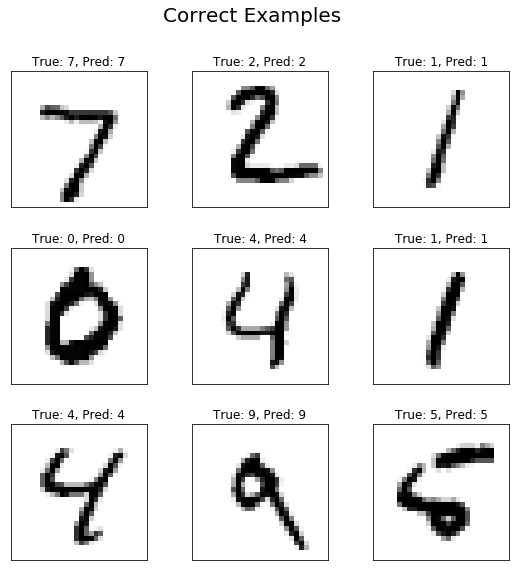

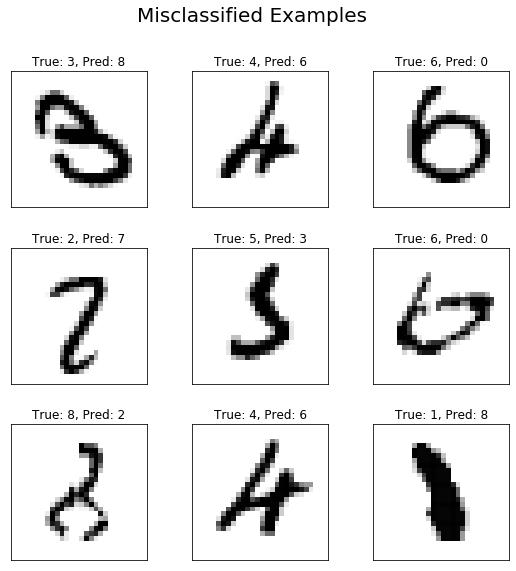

In [22]:
# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test[:1000], axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test[:1000], cls_true, cls_pred, title='Misclassified Examples')
plt.show()

In [ ]:
sess.close()